In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['legend.loc'] = 'lower right'

In [2]:
def tensorboard_style_smoothing(scalars, weight=0.9):
    """Exponential moving average smoothing in TensorBoard style"""
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return np.array(smoothed)

def plot(df=None, csv_path=None, trend_window=300, smooth_weight=0.65, lower_quantile=0.1, title=None, ylimit=None, key='episode_reward', custom_colors = None, label=None):
    if df is None:
        if csv_path:
            df = pd.read_csv(csv_path)
        else:
            raise ValueError("Must provide either csv_path or df parameter")
    
    df['trend'] = df['episode_reward'].rolling(
        trend_window, min_periods=50
    ).mean().ffill().bfill()

    threshold = df['trend'] * 0.8  # Allow 20% fluctuation
    valid_mask = df['episode_reward'] >= threshold
    filtered_df = df[valid_mask].copy()

    smoothed_values = tensorboard_style_smoothing(
        filtered_df['episode_reward'].values,
        weight=smooth_weight
    )
    filtered_df['smoothed'] = smoothed_values

    df['million_steps'] = df['step'] / 1e6  # Create million steps column
    filtered_df['million_steps'] = df['step'] / 1e6  # Create million steps column

    sns.lineplot(x ='million_steps',
                 y = key,
                 data=df,
                 linestyle='-',
                 linewidth=2,
                 alpha=0.2,
                 color=custom_colors)

    plt.plot(
        filtered_df['million_steps'],
        filtered_df['smoothed'],
        linewidth=1.2,
        color=custom_colors,
        label=label
    )

    plt.xlabel('Million Steps', fontsize=12)
    plt.ylabel('Average Return', fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.ylim(top=ylimit)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle='-', linewidth=1, color='white')

csv/Ant-v5/sac.csv #1f77b4
csv/Ant-v5/sac_plus.csv #2ca02c
/scratch/swei303/proj/ant/exp/Ant-v5/gnn/2025.04.19-2110_sac/train.csv #d62728


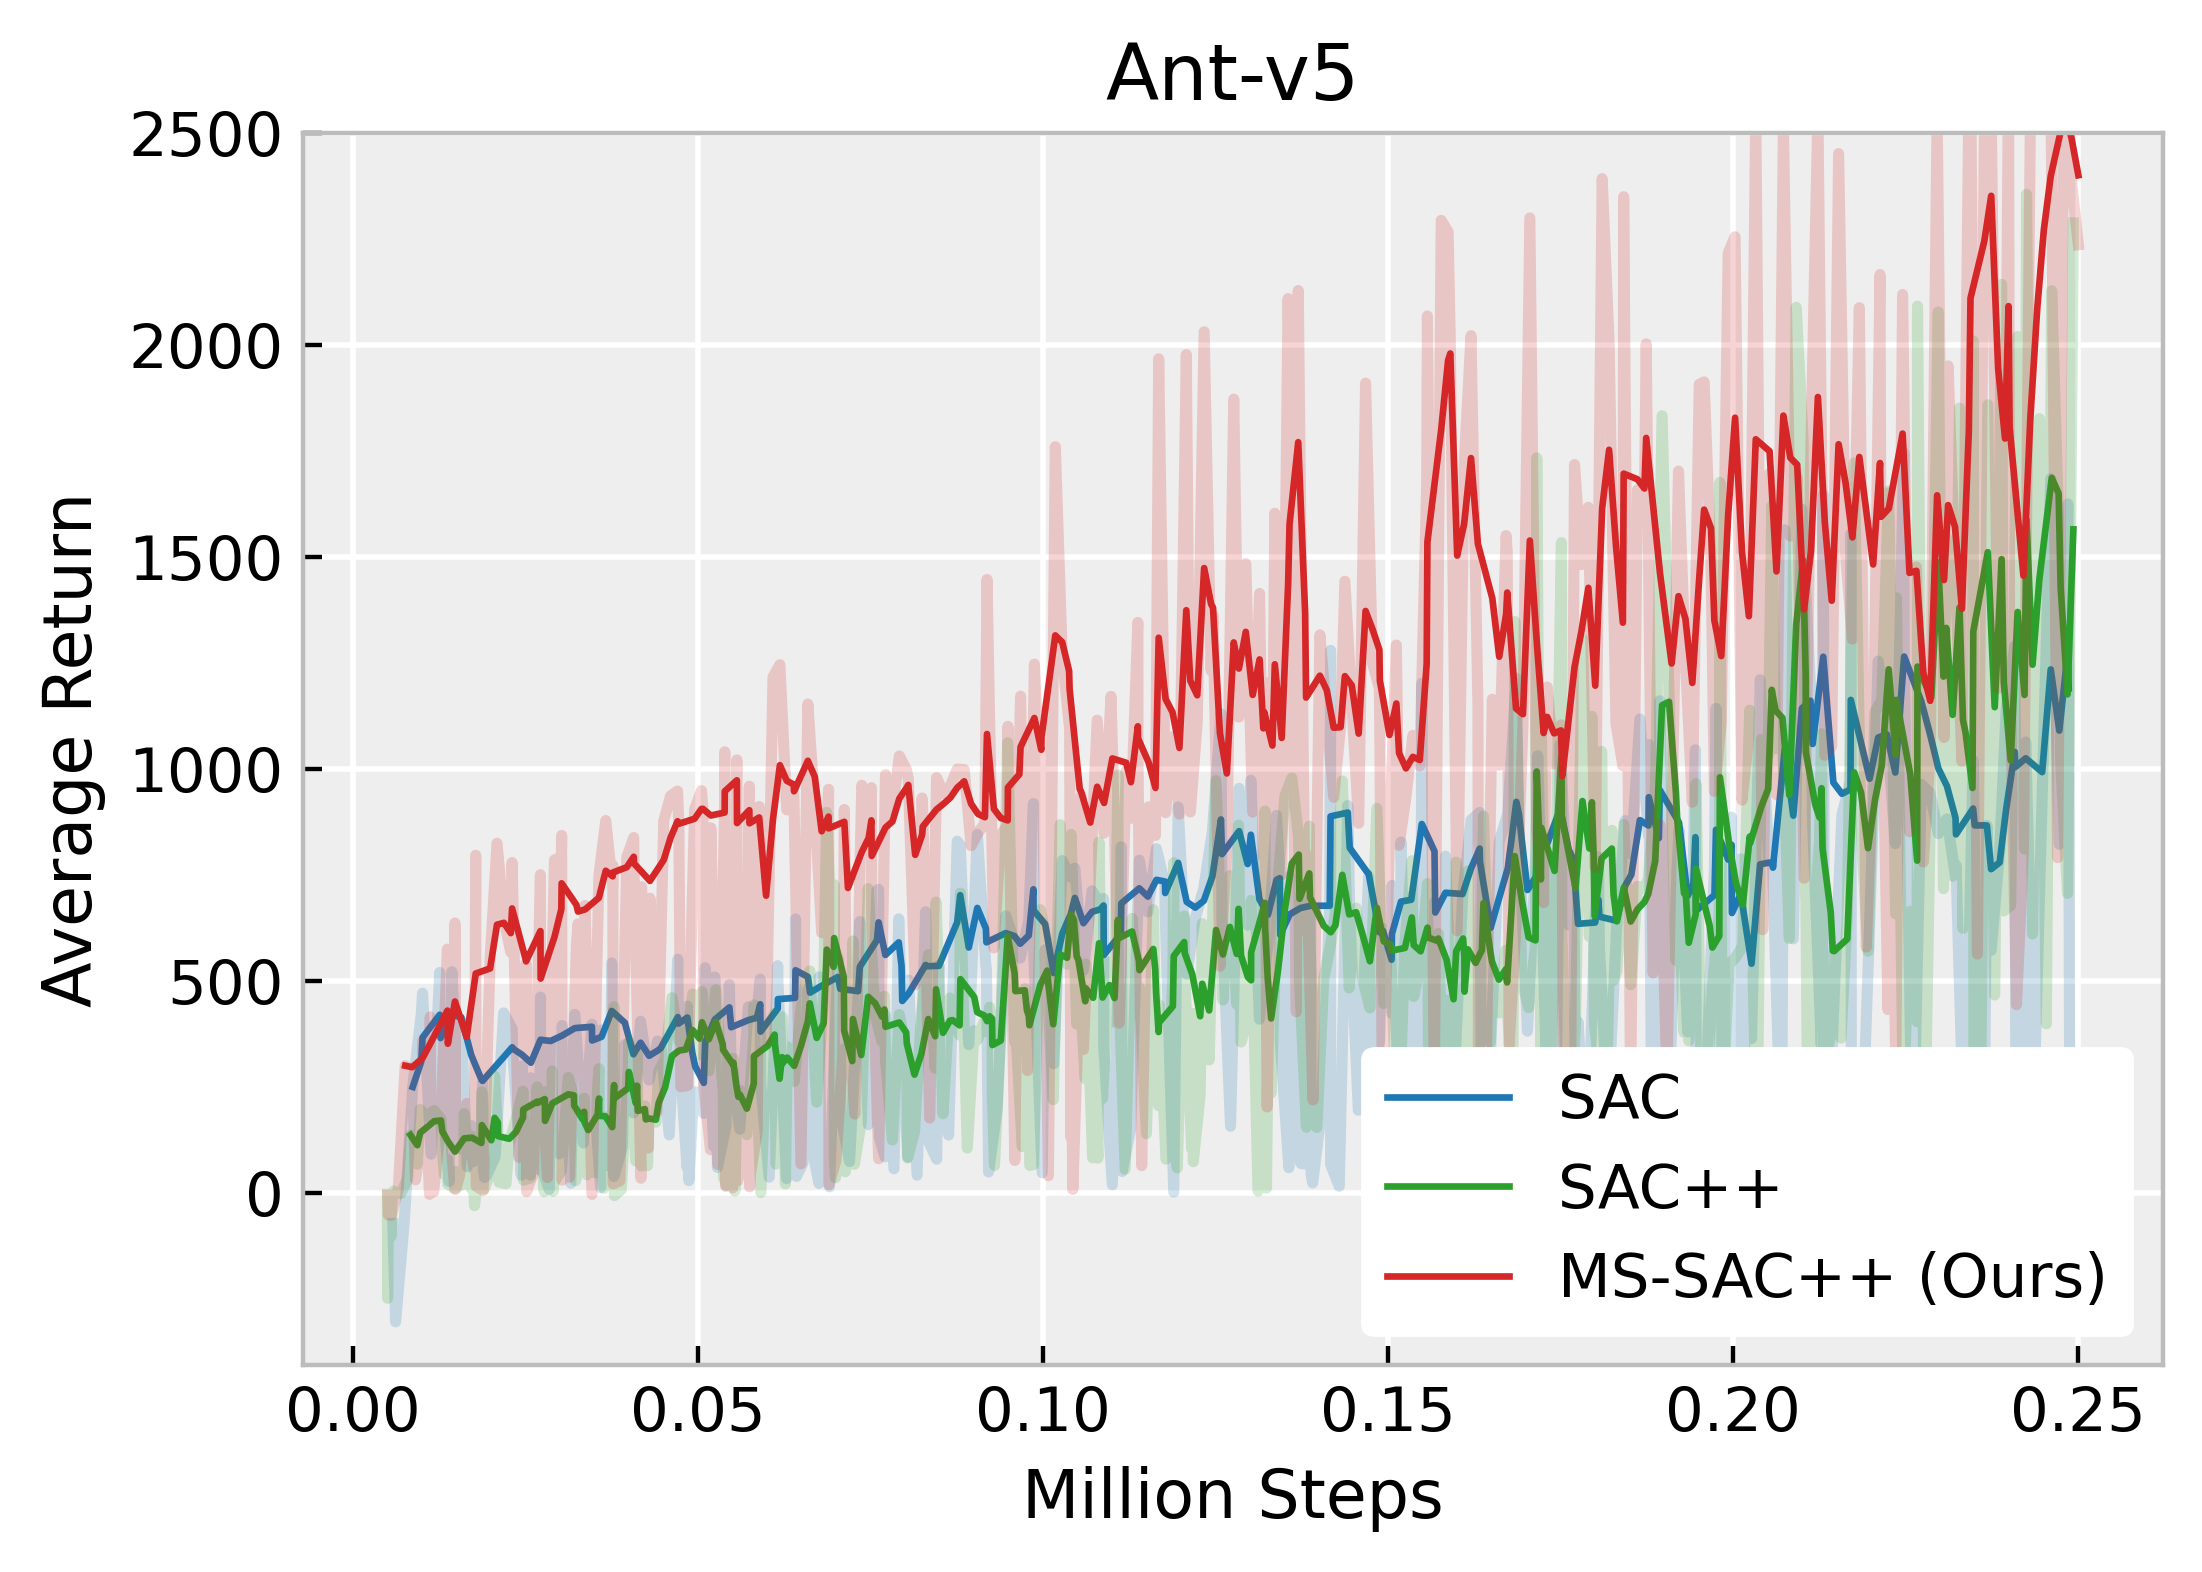

In [26]:
# robot = 'HalfCheetah-v5' # HalfCheetah-v5, Hopper-v5, Ant-v5, Humanoid-v5, Walker2d-v5
# robot = 'Walker2d-v5' # HalfCheetah-v5, Hopper-v5, Ant-v5, Humanoid-v5, Walker2d-v5
# robot = 'Hopper-v5'
# robot = 'Humanoid-v5'
robot = 'Ant-v5'

trend_window=300
smooth_weight=0.65
lower_quantile=0.1
ylimit = None
xlimit = 1e6

if robot == 'HalfCheetah-v5':
    delta_log_path = '/scratch/swei303/proj/drl-sac/exp/HalfCheetah-v5/gnn/2025.04.19-0044_sac/train.csv'
elif robot == 'Walker2d-v5':
    delta_log_path = '/scratch/swei303/proj/drl-sac/exp/Walker2d-v5/gnn/2025.04.19-0045_sac/train.csv'
    ylimit = 6000
elif robot == 'Hopper-v5':
    delta_log_path = '/scratch/swei303/proj/ant/exp/Hopper-v5/gnn/2025.04.19-1816_sac/train.csv'
elif robot == 'Humanoid-v5':
    delta_log_path = '/scratch/swei303/proj/drl-sac/exp/Humanoid-v5/gnn/2025.04.19-0146_sac/train.csv'
    xlimit=0.7*1e6
elif robot == 'Ant-v5':
    delta_log_path = '/scratch/swei303/proj/ant/exp/Ant-v5/gnn/2025.04.19-2110_sac/train.csv'
    trend_window=300
    smooth_weight=0.65
    lower_quantile=0.1
    xlimit=0.25*1e6
    ylimit=2500
    
base_dir = 'csv/{}'.format(robot)
sub_dirs = []
if os.path.exists(os.path.join(base_dir, 'sac.csv')):
    sub_dirs.append(os.path.join(base_dir, 'sac.csv'))
else:
    sub_dirs.append(-1)

if os.path.exists(os.path.join(base_dir, 'sac_plus.csv')):
    sub_dirs.append(os.path.join(base_dir, 'sac_plus.csv'))
else:
    sub_dirs.append(-1)

if os.path.exists(delta_log_path):
    sub_dirs.append(delta_log_path)
else:
    sub_dirs.append(-1)

custom_colors = [
    "#1f77b4",  # blue
    "#2ca02c",  # green
    "#d62728",  # red
    ]

labels = ['SAC', 'SAC++', 'MS-SAC++ (Ours)']

plt.figure(figsize=(6, 4))

for i, sub_dir in enumerate(sub_dirs):

    print(sub_dir, custom_colors[i])
    csv_path = sub_dir

    try:
        df = pd.read_csv(csv_path)
        if df.empty:
            print(f"Warning: File {csv_path} is empty, skipping")
            continue
    except Exception as e:
        print(f"Failed to read {csv_path}, error: {str(e)}")
        continue
    
    # 在调用plot函数前过滤数据
    df = df[df['step'] <= xlimit].copy()
    plot(df, csv_path, title=robot, trend_window=trend_window, smooth_weight=smooth_weight, 
        lower_quantile=lower_quantile, ylimit=ylimit, custom_colors=custom_colors[i], 
        label=labels[i])
    
    # plot(df, csv_path, title = robot, trend_window=trend_window, smooth_weight=smooth_weight, lower_quantile=lower_quantile, ylimit = ylimit, custom_colors=custom_colors[i], label=labels[i])

    plt.legend(
        loc="lower right",
        fontsize=11,          # font size
        frameon=True,         # show border
        framealpha=1,         # border transparency (0~1)
        facecolor="white",    # background color
        edgecolor="white",    # border color
        ncol=1,              # display in 1 column
    )
plt.savefig('output/{}.png'.format(robot), bbox_inches='tight')
plt.show()
